<a href="https://colab.research.google.com/github/leadeeerq/data-science/blob/main/StockPricePrediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stock price prediciton

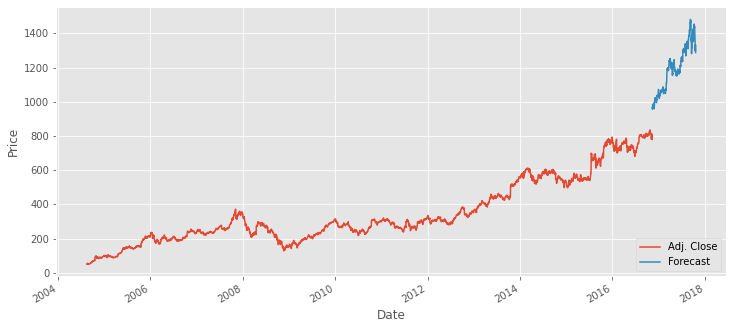

In [ ]:
!pip install Quandl

In [33]:
import pandas as pd
import quandl, math, datetime
import numpy as np
import pickle
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

##Import df from Quandl

In [7]:
data = quandl.get('WIKI/GOOGL')
data.to_csv('googl.csv')
df = pd.read_csv('googl.csv', index_col='Date', parse_dates=True)

In [8]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [9]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

In [10]:
df['pct_HL'] = (df['Adj. High'] - df['Adj. Low'])/df['Adj. Low'] * 100.0 #daily volatility/zmienność w ciągu dnia
# df['pct_HL'] = (df['Adj. High'] - df['Adj. Close'])/df['Adj. Close'] * 100.0
df['pct_change'] = (df['Adj. Close'] - df['Adj. Open'])/df['Adj. Open'] * 100.0

In [11]:
df = df[['Adj. Close', 'pct_HL', 'pct_change', 'Adj. Volume']]
df.head()

,Adj. Close,pct_HL,pct_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,8.441017,0.324968,44659000.0
2004-08-20,54.322689,8.537313,7.227007,22834300.0
2004-08-23,54.869377,4.062357,-1.227880,18256100.0
2004-08-24,52.597363,7.753210,-5.726357,15247300.0
2004-08-25,53.164113,3.966115,1.183658,9188600.0


In [12]:
forecast_col = 'Adj. Close'

###Filling nans with outliers (-99999)

In [13]:
df.fillna(-99999, inplace = True) 

###Forecast_out - predicting 0.1 of quantity of data fed

In [14]:
forecast_out = int(math.ceil(0.1 * len(df))) #Wykorzystanie x dni poprzedzających do predykcji dzisiejszego dnia
forecast_out

343

In [15]:
df['label'] = df[forecast_col].shift(-forecast_out) #Przesunięcie wyników Adj.Close o x w górę, aby mieć informację o cenie akcji po x dniach; usunięcie x pierwszych wierszy

In [16]:
df.head()

,Adj. Close,pct_HL,pct_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,8.441017,0.324968,44659000.0,214.005615
2004-08-20,54.322689,8.537313,7.227007,22834300.0,210.725489
2004-08-23,54.869377,4.062357,-1.227880,18256100.0,208.072299
2004-08-24,52.597363,7.753210,-5.726357,15247300.0,218.288837
2004-08-25,53.164113,3.966115,1.183658,9188600.0,223.309335


##Train, test split

In [17]:
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace = True)

y = np.array(df['label'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [18]:
print(len(X), len(y))

3081 3081


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##Classifier

###Linear Regression

In [20]:
clf = LinearRegression(n_jobs = -1)
clf.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [21]:
accuracy = clf.score(X_test, y_test)
accuracy

0.8786021189071224

###SVR

In [22]:
# clf = svm.SVR(kernel = 'poly')
# clf.fit(X_train, y_train)
# accuracy = clf.score(X_test, y_test)
# accuracy

##Saving the classifier using Pickle

In [23]:
with open('linearregression.pickle', 'wb') as f:
  pickle.dump(clf, f)

In [24]:
pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

##Predicition

In [34]:
forecast_set = clf.predict(X_lately)
print(forecast_set[:10], accuracy, forecast_out)

[966.46179257 956.88694876 973.27460788 982.49546832 984.03596777
 976.82175158 983.05255983 983.71759457 981.80360876 974.77121668] 0.8786021189071224 343


##Forecasting, graph

1.   Dodanie pustej kolumny 'Forecast' do df'a
2.   Zapełnienie kolumny danymi - do daty wyższej niż 'last_date' wpisana jest wartość prognozy z tablicy forecast_set
3. 'df.loc[next_date]' to indeks df'a
4. df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i] - wypełnienie komórek listą wartości np.NaN i dodanie na końcu wartości z 'forecast_set'


In [26]:
df['Forecast'] = np.nan

In [27]:
last_date = df.iloc[-1].name #Ostatnia data
last_unix = last_date.timestamp()
one_day = 86400 #sekund
next_unix = last_unix + one_day

In [28]:
last_date

Timestamp('2016-11-10 00:00:00')

In [35]:
forecast_set[:10]

array([966.46179257, 956.88694876, 973.27460788, 982.49546832,
       984.03596777, 976.82175158, 983.05255983, 983.71759457,
       981.80360876, 974.77121668])

In [30]:
for i in forecast_set:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

In [38]:
df[-348:-338]

,Adj. Close,pct_HL,pct_change,Adj. Volume,label,Forecast
Date,,,,,,
2016-11-04,781.10,2.266615,1.270582,1970603.0,1094.00,NaN
2016-11-07,802.03,1.526044,0.890622,1992570.0,1053.15,NaN
2016-11-08,811.98,2.053475,1.240602,1769069.0,1026.55,NaN
2016-11-09,805.59,2.484107,0.468927,3098510.0,1054.09,NaN
2016-11-10,780.29,5.444984,-3.667901,5909609.0,1006.94,NaN
2016-11-11,NaN,NaN,NaN,NaN,NaN,966.461793
2016-11-12,NaN,NaN,NaN,NaN,NaN,956.886949
2016-11-13,NaN,NaN,NaN,NaN,NaN,973.274608
2016-11-14,NaN,NaN,NaN,NaN,NaN,982.495468


Text(0, 0.5, 'Price')

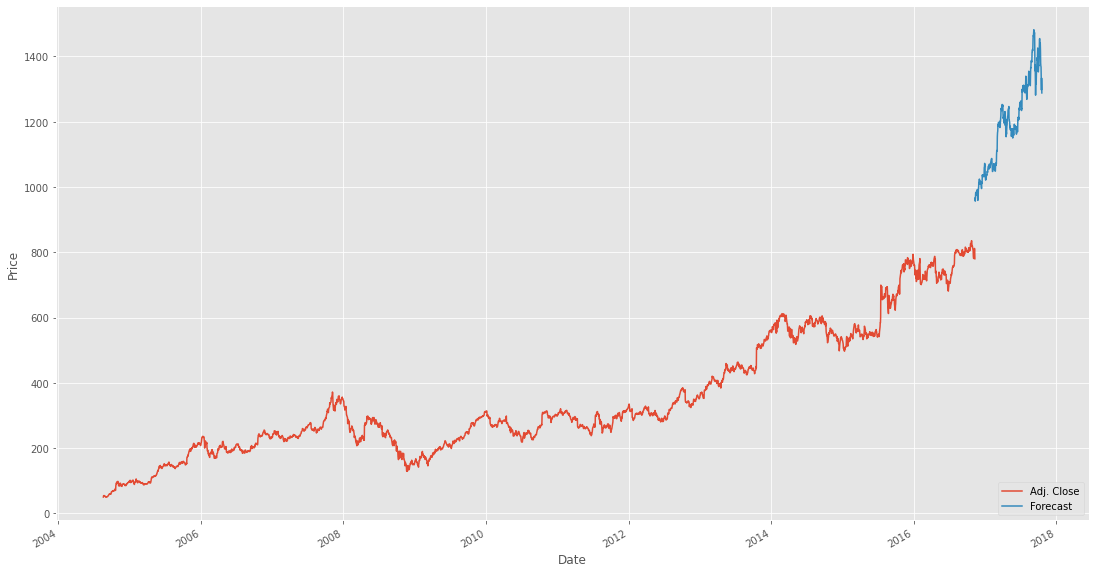

In [32]:
df['Adj. Close'].plot()
df['Forecast'].plot()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(loc = 4)
plt.xlabel('Date')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

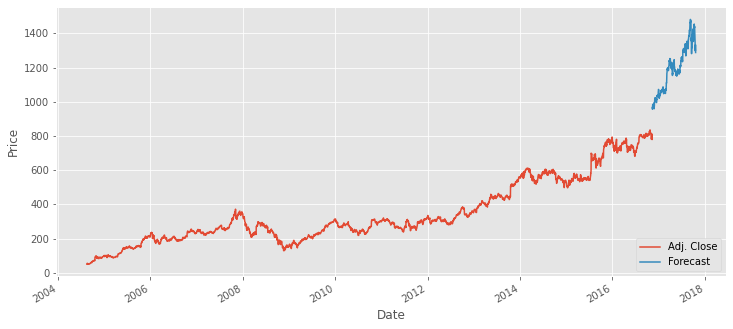

In [40]:
df['Adj. Close'].plot()
df['Forecast'].plot()
fig = plt.gcf()
fig.set_size_inches(12, 5.5)
plt.legend(loc = 4)
plt.xlabel('Date')
plt.ylabel('Price')